In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools

import networkx as nx
import scipy

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

########################################################################################################################################################################################################################

## Analyze in-host SNPs ($\Delta AF \ge 70\%$)

########################################################################################################################################################################################################################

#### Import Sample Annotation file for all patients that have been filtered by Lineage Call and Fixed SNP Distance

In [3]:
sample_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_fastq_path_names_and_JankyPipe_tags_filtered_final.csv' , sep = ',').set_index('patient_id')

In [4]:
sample_annotation.head()

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039337,NaN,1,ERR039337,longitudinal
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039338,NaN,2,ERR039338,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMJA00000000,Peru5115,1,Peru5115,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMPC00000000,Peru4668,2,Peru4668,longitudinal
2491,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMZT00000000,Peru4903,1,Peru4903,longitudinal


In [5]:
num_patients = np.shape(sample_annotation)[0] / 2
print num_patients

200


#### Load SNPs that passed Threshold for Delta Allele Frequency

In [6]:
SNP_variants_within_patients = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/SNPs_between_isolates_delta_70.pkl')

In [7]:
SNP_variants_within_patients.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,rpoB,1.0,N,H445D
1,CASALI,P251,861378,T,G,Rv0768,467,Non-Essential,aldA,1.0,N,I156S
2,BRYANT,2020E,1253207,A,G,Rv1129c,1328,Non-Essential,NaN,1.0,N,I443T
3,BRYANT,2020E,2075138,T,A,Rv1830,298,Non-Essential,NaN,1.0,N,S100T
4,BRYANT,2020E,2694727,A,G,Rv2397c,238,Essential,cysA1,1.0,N,F80L


In [8]:
np.shape(SNP_variants_within_patients)

(175, 12)

In [9]:
SNP_variants_within_patients.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,rpoB,1.0,N,H445D
1,CASALI,P251,861378,T,G,Rv0768,467,Non-Essential,aldA,1.0,N,I156S
2,BRYANT,2020E,1253207,A,G,Rv1129c,1328,Non-Essential,NaN,1.0,N,I443T
3,BRYANT,2020E,2075138,T,A,Rv1830,298,Non-Essential,NaN,1.0,N,S100T
4,BRYANT,2020E,2694727,A,G,Rv2397c,238,Essential,cysA1,1.0,N,F80L


In [10]:
print str( len(set(SNP_variants_within_patients.patient_id) ) ) + ' subjects had at least 1 SNP between longitudinal isolates'

77 subjects had at least 1 SNP between longitudinal isolates


Get list of genes with at least 1 SNP (excluding intergenic regions)

In [11]:
genes_with_SNP = []
for gene_id in list( SNP_variants_within_patients.gene_id ):
        
        if '_' not in gene_id: #not intergenic
            
            genes_with_SNP.append(gene_id)
            
genes_with_SNP = list(set(genes_with_SNP)) #get rid of redundant gene names

In [12]:
len(genes_with_SNP)

127

#### Investigate Intergenic Regions

In [13]:
SNP_variants_within_patients[SNP_variants_within_patients.SNP_type == 'I'].sort_values('ref_position')

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
113,GUERRA,KPS_68,810959,C,T,Rv0713_Rv0714,None,None,None,0.86,I,None
12,GUERRA,KPS_1,1114173,C,T,Rvnt15_Rv0997,None,None,None,1.00,I,None
31,WALKER,P000156,1179394,G,A,Rv1056_Rv1057,None,None,None,1.00,I,None
145,GUERRA,KPS_84,1340558,T,C,Rv1196_Rv1197,None,None,None,1.00,I,None
120,WITNEY,6,1348678,A,C,Rv1204c_Rv1205,None,None,None,0.92,I,None
54,CETR,2307,1673406,C,T,Rv1482c_Rv1483,None,None,None,0.82,I,None
125,WALKER,P000128,1789912,C,A,Rv1588c_Rv1589,None,None,None,1.00,I,None
89,CETR,1664,1836252,A,G,Rv1631_Rv1632c,None,None,None,1.00,I,None
144,GUERRA,KPS_81,2024741,G,C,Rv1785c_Rv1786,None,None,None,0.98,I,None
35,WALKER,P000095,2123169,T,G,Rv1872c_Rv1873,None,None,None,0.94,I,None


No intergenic region has > 1 SNP occur

#### Intergenic vs. Coding SNPs

In [14]:
np.shape(SNP_variants_within_patients[SNP_variants_within_patients.SNP_type == 'I'])

(21, 12)

21/174 SNPs are Intergenic 

In [15]:
np.shape(SNP_variants_within_patients[SNP_variants_within_patients.SNP_type != 'I'])

(154, 12)

154/174 SNPs were found in Coding regions (really 153 since 1 SNP is found in overlapping regions)

#### Drop Intergenic Regions for the rest of the analysis in this notebook

In [16]:
SNP_variants_within_patients = SNP_variants_within_patients[SNP_variants_within_patients.SNP_type != 'I']

In [17]:
np.shape(SNP_variants_within_patients)

(154, 12)

#### Take a look at specific SNPs that were called more than once

In [18]:
from collections import Counter
pd.Series( Counter( SNP_variants_within_patients.ref_position ) ).sort_values(ascending = False).head(n = 5)

223690     2
166624     2
761139     2
760314     2
4407979    1
dtype: int64

In [19]:
SNP_variants_within_patients[SNP_variants_within_patients.ref_position == 166624]

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
61,WALKER,P000027,166624,T,G,Rv0139,798,Non-Essential,NaN,0.99,S,L266L
62,WALKER,P000026,166624,T,G,Rv0139,798,Non-Essential,NaN,1.00,S,L266L


In [20]:
SNP_variants_within_patients[SNP_variants_within_patients.ref_position == 761139]

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,rpoB,1.00,N,H445D
149,GUERRA,KPS_82,761139,C,G,Rv0667,1333,Antibiotic Resistance,rpoB,0.99,N,H445D


In [21]:
SNP_variants_within_patients[SNP_variants_within_patients.ref_position == 760314]

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
48,CASALI,P052,760314,G,T,Rv0667,508,Antibiotic Resistance,rpoB,0.98,N,V170F
57,WALKER,P000059,760314,G,T,Rv0667,508,Antibiotic Resistance,rpoB,0.85,N,V170F


In [22]:
SNP_variants_within_patients[SNP_variants_within_patients.ref_position == 223690]

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
173,GUERRA,KPS_68,223690,G,A,Rv0192,127,Non-Essential,nan,0.99,N,G43R
174,GUERRA,KPS_68,223690,G,A,Rv0192A,84,Antigen,nan,0.99,S,L28L


Three SNPs actually occurred in two difference subjects, the fourth SNP is only a single mutation that occurred in a region of the genome with 2 overlapping CDS regions and as such is annotated as 2 seperate SNPs

### Add SNP Annotation

#### Parse through Mycobrowser (tuberculist) to collect function & gene names

In [23]:
mycobrowser_table = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/complete_genomes/H37Rv/Mycobrowser_Release3/Mycobacterium_tuberculosis_H37Rv_txt_v3.txt' , sep = '\t')

#drop unnecessary columns
mycobrowser_table = mycobrowser_table.loc[: , ['Refseq_ID' , 'Feature' , 'Start' , 'Stop', 'Score' , 'Strand' , 'Frame' , 'Locus' , 'Name' , 'Function' , 'Product' , 'Comments' , 'UniProt_AC' , 'Is_Pseudogene' , 'Functional_Category']]

#subset to genes with at least 1 SNP
genes_with_SNP_filter = [gene_locus in genes_with_SNP for gene_locus in list(mycobrowser_table.Locus)]
mycobrowser_table = mycobrowser_table[genes_with_SNP_filter]

#organize by Start Ref Position
mycobrowser_table.sort_values(by = ['Start'] , inplace = True)

#reset index
mycobrowser_table.reset_index(inplace = True , drop = True)

In [24]:
mycobrowser_table.head()

,Refseq_ID,Feature,Start,Stop,Score,Strand,Frame,Locus,Name,Function,Product,Comments,UniProt_AC,Is_Pseudogene,Functional_Category
0,NC_000962.3,CDS,5240,7267,.,+,0.0,Rv0005,gyrB,DNA gyrase negatively supercoils closed circul...,DNA gyrase (subunit B) GyrB (DNA topoisomerase...,"Rv0005, (MTCY10H4.03), len: 675 aa. GyrB, DNA ...",P9WG45,No,information pathways
1,NC_000962.3,CDS,7302,9818,.,+,0.0,Rv0006,gyrA,DNA gyrase negatively supercoils closed circul...,DNA gyrase (subunit A) GyrA (DNA topoisomerase...,"Rv0006, (MTCY10H4.04), len: 838 aa. GyrA, DNA ...",P9WG47,No,information pathways
2,NC_000962.3,CDS,43562,46471,.,+,0.0,Rv0041,leuS,Involved in translation mechanism [catalytic a...,Probable leucyl-tRNA synthetase LeuS (leucine-...,"Rv0041, (MTCY21D4.04), len: 969 aa. Probable l...",P9WFV1,No,information pathways
3,NC_000962.3,CDS,104805,105215,.,-,0.0,Rv0095c,Rv0095c,Function unknown,Conserved hypothetical protein,"Rv0095c, (MTCY251.14c), len: 136 aa. Member of...",Q10891,No,insertion seqs and phages
4,NC_000962.3,CDS,110001,117539,.,+,0.0,Rv0101,nrp,Involved in lipid metabolism.,Probable peptide synthetase Nrp (peptide synth...,"Rv0101, (MTCY251.20), len: 2512 aa. Probable n...",Q10896,No,lipid metabolism


In [25]:
np.shape(mycobrowser_table)

(127, 15)

In [26]:
#save table for later
mycobrowser_table.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/variant_calling/longitudinal_SNPs/mycobrowser_info_for_genes_with_SNPs.csv')

Create a table for just the gene names

In [27]:
gene_names_from_mycobrowser = mycobrowser_table.loc[: , ['Locus' , 'Name']]

In [28]:
gene_names_from_mycobrowser.head()

,Locus,Name
0,Rv0005,gyrB
1,Rv0006,gyrA
2,Rv0041,leuS
3,Rv0095c,Rv0095c
4,Rv0101,nrp


#### Parse through Annotation Table from NCBI to collect gene names

In [29]:
NCBI_feature_table = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/complete_genomes/H37Rv/H37Rv_000195955v2/GCF_000195955.2_ASM19595v2_feature_table.txt' , sep = '\t')

#drop unnecessary columns
NCBI_feature_table = NCBI_feature_table.loc[: , ['# feature' , 'assembly_unit' , 'genomic_accession' , 'start' , 'end' , 'strand' , 'product_accession' , 'name' , 'symbol' , 'GeneID' , 'locus_tag' , 'feature_interval_length']]

#keep only 'gene' regions
NCBI_feature_table_gene_filter = [gene == 'gene' for gene in list(NCBI_feature_table.loc[: , '# feature']) ]
NCBI_feature_table = NCBI_feature_table[NCBI_feature_table_gene_filter]

#subset to genss with at least 1 SNP
genes_with_SNP_filter = [gene_locus in genes_with_SNP for gene_locus in list(NCBI_feature_table.loc[: , 'locus_tag'])]
NCBI_feature_table = NCBI_feature_table[genes_with_SNP_filter]

#reset index
NCBI_feature_table.reset_index(inplace = True , drop = True)

In [30]:
NCBI_feature_table.head()

,# feature,assembly_unit,genomic_accession,start,end,strand,product_accession,name,symbol,GeneID,locus_tag,feature_interval_length
0,gene,Primary Assembly,NC_000962.3,5240,7267,+,NaN,NaN,gyrB,887081,Rv0005,2028
1,gene,Primary Assembly,NC_000962.3,7302,9818,+,NaN,NaN,gyrA,887105,Rv0006,2517
2,gene,Primary Assembly,NC_000962.3,43562,46471,+,NaN,NaN,leuS,887040,Rv0041,2910
3,gene,Primary Assembly,NC_000962.3,104805,105215,-,NaN,NaN,NaN,886940,Rv0095c,411
4,gene,Primary Assembly,NC_000962.3,110001,117539,+,NaN,NaN,nrp,886951,Rv0101,7539


In [31]:
np.shape(NCBI_feature_table)

(126, 12)

Create a table for just the gene names

In [32]:
gene_names_from_NCBI = NCBI_feature_table.loc[: , ['locus_tag' , 'symbol']]

#re-name to match name from Mycobrowser category
gene_names_from_NCBI.rename(index=str, columns={"locus_tag": "Locus"} , inplace = True)

#replate 'NaN' with locus tags
for gene_i in gene_names_from_NCBI.index:

    #if element is NOT a string    
    if isinstance(gene_names_from_NCBI.loc[gene_i , 'symbol'] , basestring) == False:
        
        #if element is a NaN value
        if np.isnan(gene_names_from_NCBI.loc[gene_i , 'symbol']) == True:
            
            #change gene name to locus tag
            gene_names_from_NCBI.loc[gene_i , 'symbol'] = gene_names_from_NCBI.loc[gene_i , 'Locus']

In [33]:
gene_names_from_NCBI.head()

,Locus,symbol
0,Rv0005,gyrB
1,Rv0006,gyrA
2,Rv0041,leuS
3,Rv0095c,Rv0095c
4,Rv0101,nrp


#### Gene Names from both NCBI Feature Annotation & Mycobrowser

In [34]:
gene_names_from_NCBI_and_Myco = gene_names_from_mycobrowser.merge(gene_names_from_NCBI , how = 'inner' , on = 'Locus')

In [35]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(gene_names_from_NCBI_and_Myco)

,Locus,Name,symbol
0,Rv0005,gyrB,gyrB
1,Rv0006,gyrA,gyrA
2,Rv0041,leuS,leuS
3,Rv0095c,Rv0095c,Rv0095c
4,Rv0101,nrp,nrp
5,Rv0105c,rpmB1,rpmB1
6,Rv0107c,ctpI,ctpI
7,Rv0139,Rv0139,Rv0139
8,Rv0170,mce1B,mce1B
9,Rv0192,Rv0192,Rv0192


Find genes for which Name from Mycobrowser does not match symbol for NCBI

In [36]:
gene_names_from_NCBI_and_Myco[gene_names_from_NCBI_and_Myco.Name != gene_names_from_NCBI_and_Myco.symbol]

,Locus,Name,symbol
23,Rv0618,galTa,galT
46,Rv1146,mmpL13b,Rv1146


#### Change gene *symbol* to the assigned Name from Mycobrowser

Gene Names from Mycobrowser Annotation Table

In [37]:
#table for Gene Names from Mycobrowser
gene_names_from_mycobrowser = mycobrowser_table.loc[: , ['Locus' , 'Name']]

#rename to merge with SNP-variants DF
gene_names_from_mycobrowser.rename(index=str, columns={"Locus": "gene_id"} , inplace = True)

In [38]:
gene_names_from_mycobrowser.head()

,gene_id,Name
0,Rv0005,gyrB
1,Rv0006,gyrA
2,Rv0041,leuS
3,Rv0095c,Rv0095c
4,Rv0101,nrp


In [39]:
SNP_variants_within_patients.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,rpoB,1.0,N,H445D
1,CASALI,P251,861378,T,G,Rv0768,467,Non-Essential,aldA,1.0,N,I156S
2,BRYANT,2020E,1253207,A,G,Rv1129c,1328,Non-Essential,NaN,1.0,N,I443T
3,BRYANT,2020E,2075138,T,A,Rv1830,298,Non-Essential,NaN,1.0,N,S100T
4,BRYANT,2020E,2694727,A,G,Rv2397c,238,Essential,cysA1,1.0,N,F80L


In [40]:
#merge SNP variants DF with gene names from mycobrowser
SNP_variants_within_patients = SNP_variants_within_patients.merge(gene_names_from_mycobrowser , how = 'inner' , on = 'gene_id')

#drop gene 'symbols' column from H37Rv annotation file in lab folder
SNP_variants_within_patients.drop('gene_symbol', axis = 1 , inplace = True)

#rename 'Name' for gene names to 'symbol' for downstream analysis
SNP_variants_within_patients.rename(index=str, columns={"Name": "symbol"} , inplace = True)

In [41]:
SNP_variants_within_patients.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,alt_AF_diff,SNP_type,AA_change,symbol
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,1.00,N,H445D,rpoB
1,CASALI,P052,760314,G,T,Rv0667,508,Antibiotic Resistance,0.98,N,V170F,rpoB
2,WALKER,P000059,760314,G,T,Rv0667,508,Antibiotic Resistance,0.85,N,V170F,rpoB
3,WALKER,P000227,761277,A,T,Rv0667,1471,Antibiotic Resistance,0.99,N,I491F,rpoB
4,CETR,2511,761140,A,C,Rv0667,1334,Antibiotic Resistance,1.00,N,H445P,rpoB


### Search for Genes that were convergent in multiple patients

In [42]:
#For each gene, store the number of subjects for which a SNP appears in the paired isolates from that subject
num_subjects_with_SNP_on_gene = {}

for gene_id in list(set(SNP_variants_within_patients.gene_id)):
    
    #look at the number of unique patients
    num_subjects_with_SNP_on_gene[gene_id] = len( set( SNP_variants_within_patients[SNP_variants_within_patients.gene_id == gene_id].patient_id ) )
    
num_subjects_with_SNP_on_gene = pd.Series(num_subjects_with_SNP_on_gene)

#get list of genes that had a mutation between paired isolates in multiple subjects
gene_ids_with_SNPs_in_multiple_patients = num_subjects_with_SNP_on_gene[num_subjects_with_SNP_on_gene > 1].index

In [43]:
#create DataFrame that stores information for each Gene that has SNPs within multiple subjects
SNP_variants_in_multiple_patients = pd.DataFrame(columns = ['gene_category' , 'symbol' , 'num_patients' , 'num_sSNPs' , 'num_nSNPs' , 'avg_alt_AF_diff'])

for gene_id in gene_ids_with_SNPs_in_multiple_patients:
    
    SNPs_for_gene_id = SNP_variants_within_patients[SNP_variants_within_patients.gene_id == gene_id]
    
    Gene_Category = list(SNPs_for_gene_id.gene_category)[0] #all SNPs have the same Gene Category
    symbol = list(SNPs_for_gene_id.symbol)[0] #all SNPs have the same symbol
    
    num_patients = len( set( SNP_variants_within_patients[SNP_variants_within_patients.gene_id == gene_id].patient_id ) )
    num_sSNPs = np.shape(SNPs_for_gene_id[SNPs_for_gene_id.SNP_type == 'S'])[0]
    num_nSNPs = np.shape(SNPs_for_gene_id[SNPs_for_gene_id.SNP_type == 'N'])[0]
    avg_alt_AF_diff = np.mean(SNPs_for_gene_id.alt_AF_diff)
    
    #append to DataFrame
    SNP_variants_in_multiple_patients.loc[gene_id , :] = [Gene_Category , symbol , num_patients , num_sSNPs , num_nSNPs , avg_alt_AF_diff]
    
#sort dataframe
SNP_variants_in_multiple_patients.sort_values(by = ['num_patients' , 'gene_category'] , ascending = [False , True] , inplace = True)

#make Gene ID a column
SNP_variants_in_multiple_patients['gene_id'] = list(SNP_variants_in_multiple_patients.index)

#re-index
SNP_variants_in_multiple_patients.reset_index(inplace = True , drop = True)

In [44]:
SNP_variants_in_multiple_patients

,gene_category,symbol,num_patients,num_sSNPs,num_nSNPs,avg_alt_AF_diff,gene_id
0,Antibiotic Resistance,rpoB,6,0,6,0.968333,Rv0667
1,Antibiotic Resistance,gyrA,4,0,4,0.925,Rv0006
2,Antibiotic Resistance,katG,4,0,4,0.925,Rv1908c
3,Antibiotic Resistance,rpoC,3,0,3,0.98,Rv0668
4,Antibiotic Resistance,embB,3,0,3,0.983333,Rv3795
5,Antibiotic Resistance,ethA,2,0,2,0.86,Rv3854c
6,Non-Essential,Rv0139,2,2,0,0.995,Rv0139
7,Non-Essential,Rv0895,2,1,1,0.99,Rv0895
8,Non-Essential,Rv1543,2,0,2,0.985,Rv1543


In [45]:
#store DataFrame as a CSV
SNP_variants_in_multiple_patients.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/variant_calling/longitudinal_SNPs/genes_mutated_within_multiple_subjects.csv')

##### Get list of genes that show evidence of parallel evolution

In [46]:
parallel_evol_genes_by_SNPs = list(SNP_variants_in_multiple_patients.gene_id)

In [47]:
len(parallel_evol_genes_by_SNPs)

9

In [48]:
print parallel_evol_genes_by_SNPs

['Rv0667', 'Rv0006', 'Rv1908c', 'Rv0668', 'Rv3795', 'Rv3854c', 'Rv0139', 'Rv0895', 'Rv1543']


########################################################################################################################################################################################################################

## Create Circos Plot

########################################################################################################################################################################################################################

### Create DataFrame containing count of SNPs at each Reference Position

In [49]:
#split DataFrame up into Syn, NSyn & Intergenic SNPs
S_SNP_variants_within_patients_DF = SNP_variants_within_patients[SNP_variants_within_patients.SNP_type == 'S']
N_SNP_variants_within_patients_DF = SNP_variants_within_patients[SNP_variants_within_patients.SNP_type == 'N']
I_SNP_variants_within_patients_DF = SNP_variants_within_patients[SNP_variants_within_patients.SNP_type == 'I']

#list of genomic coordinates for all SNPs across genome (w/ at least 1 SNP)
variant_list_S = list(S_SNP_variants_within_patients_DF.ref_position.sort_values() )
variant_list_N = list(N_SNP_variants_within_patients_DF.ref_position.sort_values() )
variant_list_I = list(I_SNP_variants_within_patients_DF.ref_position.sort_values() )

#list of (unique) genomic coordinates for all bases in H37Rv
genome_coverage_S = np.sort( np.array( list( set( S_SNP_variants_within_patients_DF.ref_position ) ) ) )
genome_coverage_N = np.sort( np.array( list( set( N_SNP_variants_within_patients_DF.ref_position ) ) ) )
genome_coverage_I = np.sort( np.array( list( set( I_SNP_variants_within_patients_DF.ref_position ) ) ) )

#list of the (count) number of paired-isolates each unique SNP appears in
variant_counter_S = [variant_list_S.count(pos) for pos in genome_coverage_S]
variant_counter_N = [variant_list_N.count(pos) for pos in genome_coverage_N]
variant_counter_I = [variant_list_I.count(pos) for pos in genome_coverage_I]

#create a series that stores all obsevered variant positions and observed frequency of each position
genomic_position_variant_count_S = pd.DataFrame(index = genome_coverage_S)
genomic_position_variant_count_S['variant_count'] = variant_counter_S
genomic_position_variant_count_S['ref_position'] = genome_coverage_S

genomic_position_variant_count_N = pd.DataFrame(index = genome_coverage_N)
genomic_position_variant_count_N['variant_count'] = variant_counter_N
genomic_position_variant_count_N['ref_position'] = genome_coverage_N

genomic_position_variant_count_I = pd.DataFrame(index = genome_coverage_I)
genomic_position_variant_count_I['variant_count'] = variant_counter_I
genomic_position_variant_count_I['ref_position'] = genome_coverage_I

#append the gene_id to each SNP (get gene ids corresponding to the genomic location for each SNP from parent SNP dataframe)
ref_position_gene_filter = SNP_variants_within_patients.loc[: , ['ref_position' , 'gene_id']].duplicated(subset = 'ref_position' , keep = 'first')
ref_position_gene_filter = [not dupl for dupl in ref_position_gene_filter]
ref_positions_gene_ids = SNP_variants_within_patients.loc[: , ['ref_position' , 'gene_id']][ref_position_gene_filter]

#merge gene_ids with the variant counts dataframe
genomic_position_variant_count_S = pd.merge(genomic_position_variant_count_S, ref_positions_gene_ids, how='left', on='ref_position')
genomic_position_variant_count_N = pd.merge(genomic_position_variant_count_N, ref_positions_gene_ids, how='left', on='ref_position')
genomic_position_variant_count_I = pd.merge(genomic_position_variant_count_I, ref_positions_gene_ids, how='left', on='ref_position')

In [50]:
genomic_position_variant_count_S.head(n=2)

,variant_count,ref_position,gene_id
0,1,105060,Rv0095c
1,1,105063,Rv0095c


In [51]:
genomic_position_variant_count_N.head(n=2)

,variant_count,ref_position,gene_id
0,1,6742,Rv0005
1,1,7521,Rv0006


##### Create plot of all SNP locations and observed frequencies for each SNP

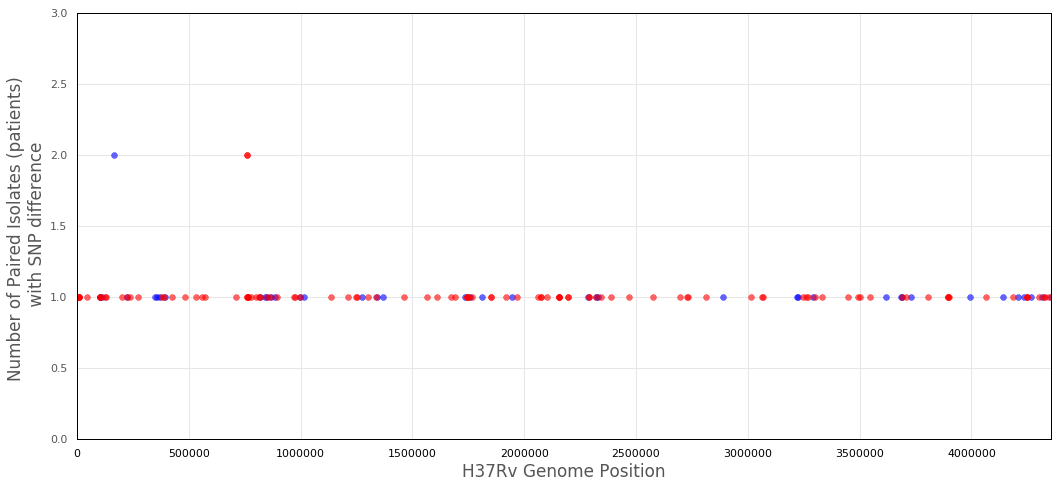

In [52]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '0.9'
plt.rcParams.update({'font.size': 14})

fig , ax = plt.subplots()
plt.scatter(genomic_position_variant_count_S.ref_position , genomic_position_variant_count_S.variant_count , color = 'blue' , marker = 'o' , s = 35 , alpha = 0.6 )
plt.scatter(genomic_position_variant_count_N.ref_position , genomic_position_variant_count_N.variant_count , color = 'red' , marker = 'o' , s = 35 , alpha = 0.6 )

plt.ylabel('Number of Paired Isolates (patients) \n with SNP difference')
plt.xlabel('H37Rv Genome Position')

plt.xlim([0  , max(genomic_position_variant_count_S.ref_position) ])
plt.ylim([0 , max( max(genomic_position_variant_count_S.variant_count) , max(genomic_position_variant_count_N.variant_count) ) + 1])

fig = plt.gcf()
fig.set_size_inches(15, 7)
fig.tight_layout()

plt.show()

### Statistical Test (Genes)

In [53]:
#load CSV file for Gene Categories
gene_categories = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv').set_index('name')

#get list of all Genes to consider in Significance Testing
ALL_Gene_IDs = []
for gene_category in ['Essential' , 'Non-Essential' , 'Antigen' , 'Antibiotic Resistance' , 'PE/PPE']: #only genes included in analysis (dropped intergenic & mobile genetic element regions)
    ALL_Gene_IDs = ALL_Gene_IDs + list( gene_categories[gene_categories.Gene_Category == gene_category].gene_id )

#get list of all genes that had at least 1 SNP across all patients
genes_with_SNP = list(set(list(SNP_variants_within_patients.gene_id))) 

#create Series of all genes that will hold how many SNPs appeared on each gene
ALL_SNP_count_per_Gene = pd.Series()

for gene_id in ALL_Gene_IDs:
    
    if gene_id in genes_with_SNP: #gene had at least 1 SNP in gene across all patients
        
        #all SNPs that occurred on gene
        SNPs_on_gene = SNP_variants_within_patients[SNP_variants_within_patients.gene_id == gene_id]
        number_of_SNPs = np.shape(SNPs_on_gene)[0]
        
        ALL_SNP_count_per_Gene[gene_id] = number_of_SNPs
        
    else:
        ALL_SNP_count_per_Gene[gene_id] = 0.0
        
ALL_SNP_count_per_Gene.sort_values(ascending = False, inplace = True)

In [54]:
ALL_SNP_count_per_Gene.head(n=15)

Rv0667     6.0
Rv0095c    5.0
Rv1908c    4.0
Rv0006     4.0
Rv3795     3.0
Rv3478     3.0
Rv0668     3.0
Rv0139     2.0
Rv3854c    2.0
Rv1543     2.0
Rv1641     2.0
Rv2043c    2.0
Rv0895     2.0
Rv2950c    1.0
Rv2305     1.0
dtype: float64

#### Get length of genome & Calculate Average Distance between Genomes

In [55]:
#load CSV file with Genome Annotation
reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

#include only relevant genes in genome-length
genome_length_sum = reference_genome_annotation.loc[ALL_Gene_IDs , 'length'].sum()

#get length of each gene 
gene_lengths_for_each_gene = reference_genome_annotation.length[ALL_SNP_count_per_Gene.index]

#number of isolate pairs
num_pairs = float(num_patients)

#number of SNP sites across all genes
num_SNP_sites = np.sum(ALL_SNP_count_per_Gene)

# Calculate average distance between strains
avg_dist_btwn_patients = float(num_SNP_sites) / num_pairs

#NULL HYP: Poisson w/ lambda = (num_pairs) * (avg_dist_btwn_patients) * (gene_length / genome_length_sum)
null_rate_per_gene = (num_pairs) * avg_dist_btwn_patients * (1.0 / float(genome_length_sum)) * gene_lengths_for_each_gene

#Compare Null Rate with Observerd Frequency and calculate p-value
def calc_signif_gene(observed_frequency , gene_i):
    
    null_rate_gene_i = null_rate_per_gene[gene_i]
    p_value = (1.0 - scipy.stats.poisson.cdf(observed_frequency , null_rate_gene_i))
    
    return p_value

#### Calculate significance of within-host variation for each Gene

In [56]:
p_values_for_genes = pd.Series(index = ALL_SNP_count_per_Gene.index)

for gene_id in ALL_SNP_count_per_Gene.index:
    
    observed_freq = ALL_SNP_count_per_Gene[gene_id]
    
    p_val_gene_i = calc_signif_gene(observed_freq , gene_id)
    
    p_values_for_genes[gene_id] = p_val_gene_i
    
#sort smallest to largest p-values
p_values_for_genes.sort_values(ascending = True , inplace = True)

In [57]:
p_values_for_genes.head()

Rv0095c    2.353673e-14
Rv0667     1.635260e-10
Rv1908c    3.833550e-08
Rv0006     7.065965e-08
Rv3478     1.827324e-07
dtype: float64

In [58]:
p_values_for_genes.tail()

Rv3825c    0.220683
Rv2524c    0.302240
Rv3347c    0.309401
Rv3350c    0.353204
Rv2048c    0.385359
dtype: float64

Number of genes tested

In [59]:
len(ALL_SNP_count_per_Gene)

3886

Find cut-off value consistent with Bonferroni correction

In [60]:
Bonf_cutoff = 0.05 / float(len(ALL_SNP_count_per_Gene))
Bonf_cutoff_scaled = -1.0*np.log10( Bonf_cutoff)

In [61]:
Bonf_cutoff_scaled

4.890532791927745

In [62]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='0.85'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

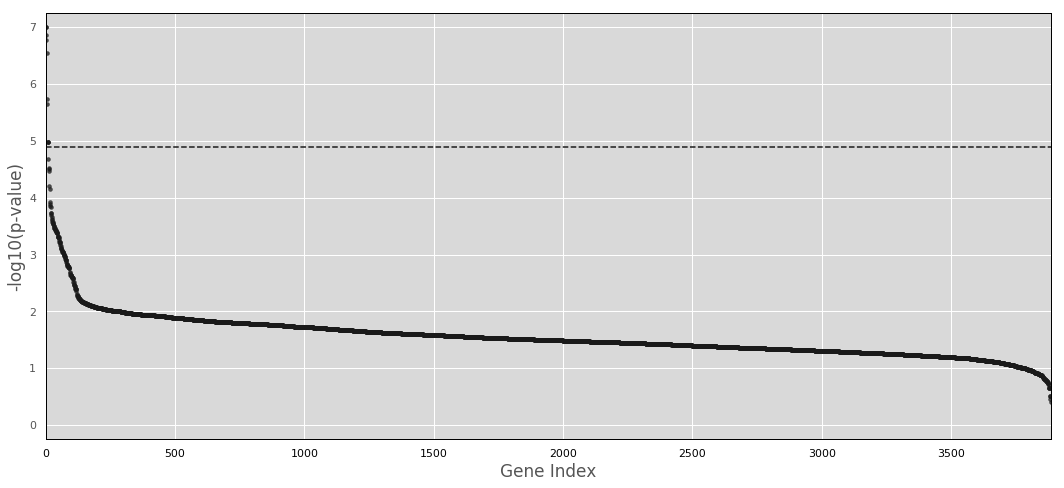

In [63]:
fig, ax = plt.subplots()
plt.scatter(range(0 , len(p_values_for_genes)) , -1.0*np.log10( p_values_for_genes + 0.0000001) , s = 15 , c = 'k' , alpha = 0.75 , edgecolors = 'k')
ax.plot( (0 , len(p_values_for_genes) ) , (Bonf_cutoff_scaled, Bonf_cutoff_scaled) , 'k--' , linewidth = 1.5)

ax.set_ylabel('-log10(p-value)')
ax.set_xlabel('Gene Index')

plt.xlim([0  , len(p_values_for_genes) ])
plt.ylim([-.25 , max( -1.0*np.log10( p_values_for_genes + 0.0000001 ) + 0.25)])

fig = plt.gcf()
fig.set_size_inches(15, 7)
fig.tight_layout()

plt.show()

#### Construct Manhattan Plot

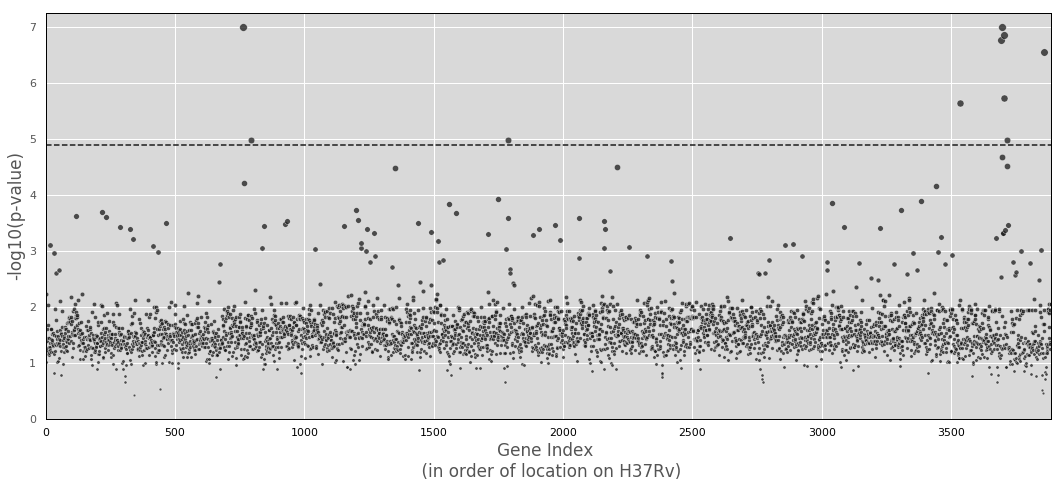

In [64]:
fig, ax = plt.subplots()

for point_x , point_y in zip(range(0 , len(p_values_for_genes)) , -1.0*np.log10( p_values_for_genes[ALL_Gene_IDs] + 0.0000001)):

    plt.scatter( point_x , point_y  , s = 8*point_y + 4, c = 'k' , alpha = 0.75 , edgecolors = 'white')

ax.plot( (0 , len(p_values_for_genes) ) , (Bonf_cutoff_scaled, Bonf_cutoff_scaled) , 'k--' , linewidth = 1.5)

plt.xlim([0  , len(p_values_for_genes) ])
plt.ylim([0.0, max( -1.0*np.log10( p_values_for_genes + 0.0000001 ) + 0.25)])

ax.set_ylabel('-log10(p-value)')
ax.set_xlabel('Gene Index \n (in order of location on H37Rv)')

fig = plt.gcf()
fig.set_size_inches(15, 7)
fig.tight_layout()

plt.show()

#### Get list of genes that have (and do not have) a significant amount of variation

In [65]:
#get list of genes that have a significant amount of variation on them
signif_genes_by_SNPs = list( p_values_for_genes[ALL_Gene_IDs][ -1.0*np.log10( p_values_for_genes + 0.0000001) >= Bonf_cutoff_scaled].index )

In [66]:
len(signif_genes_by_SNPs)

10

In [67]:
print signif_genes_by_SNPs

['Rv0095c', 'Rv0139', 'Rv1543', 'Rv1641', 'Rv0006', 'Rv0667', 'Rv1908c', 'Rv2043c', 'Rv3795', 'Rv3478']


In [68]:
#get list of genes that do not have a significant amount of variation on them (but still have at least 1 SNP)
genes_with_SNPs = set( ALL_SNP_count_per_Gene[ALL_SNP_count_per_Gene > 0].index )

non_signif_genes_by_SNPs = genes_with_SNPs - set(signif_genes_by_SNPs)

In [69]:
print list(non_signif_genes_by_SNPs)

['Rv1086', 'Rv2434c', 'Rv0470c', 'Rv1124', 'Rv1945', 'Rv1484', 'Rv0304c', 'Rv0792c', 'Rv1716', 'Rv3733c', 'Rv2566', 'Rv0293c', 'Rv2040c', 'Rv3623', 'Rv0041', 'Rv1433', 'Rv2751', 'Rv1533', 'Rv2435c', 'Rv2754c', 'Rv0355c', 'Rv2500c', 'Rv3299c', 'Rv2070c', 'Rv0698', 'Rv3554', 'Rv0284', 'Rv0757', 'Rv0200', 'Rv0618', 'Rv0773c', 'Rv0876c', 'Rv2205c', 'Rv0442c', 'Rv0101', 'Rv3877', 'Rv3136', 'Rv3320c', 'Rv1855c', 'Rv2088', 'Rv0728c', 'Rv1227c', 'Rv3240c', 'Rv2128', 'Rv0668', 'Rv3840', 'Rv0192', 'Rv1742', 'Rv0755c', 'Rv0105c', 'Rv3826', 'Rv3302c', 'Rv0170', 'Rv3128c', 'Rv1563c', 'Rv1944c', 'Rv1818c', 'Rv1129c', 'Rv1610', 'Rv1196', 'Rv1694', 'Rv1541c', 'Rv3919c', 'Rv0908', 'Rv0005', 'Rv1171', 'Rv2917', 'Rv0679c', 'Rv0482', 'Rv2700', 'Rv3390', 'Rv2974c', 'Rv2950c', 'Rv0800', 'Rv2946c', 'Rv0768', 'Rv0872c', 'Rv3803c', 'Rv2064', 'Rv2065', 'Rv1306', 'Rv1146', 'Rv0726c', 'Rv0107c', 'Rv1015c', 'Rv3082c', 'Rv3786c', 'Rv0329c', 'Rv1830', 'Rv3698', 'Rv3343c', 'Rv0404', 'Rv0752c', 'Rv2305', 'Rv0895', 'Rv

### Output Data for Circos Plot

#### SNP Scatter Plot - sSNP

In [70]:
sSNPs = genomic_position_variant_count_S.variant_count
scatter_gene_sSNP_DF = pd.DataFrame(index = sSNPs.index)
    
scatter_gene_sSNP_DF['chromosome'] = ['TB1'] * len(scatter_gene_sSNP_DF.index)
scatter_gene_sSNP_DF['start_coord'] = genomic_position_variant_count_S.ref_position.apply(int)
scatter_gene_sSNP_DF['end_coord'] = genomic_position_variant_count_S.ref_position.apply(int)
scatter_gene_sSNP_DF['pvalue'] = sSNPs

#drop index (genes) and replace with chromosome
scatter_gene_sSNP_DF.set_index('chromosome' , drop = True , inplace = True)

###############################################################

#export as space delimited txt file
file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/circos_files/scatter_manhattan_SNPs/data/gene_sSNPs_manhattan.txt'

scatter_gene_sSNP_DF.to_csv(file_name , sep = ' ' , header = False)
scatter_gene_sSNP_DF.head()

,start_coord,end_coord,pvalue
chromosome,,,
TB1,105060,105060,1
TB1,105063,105063,1
TB1,114494,114494,1
TB1,166624,166624,2
TB1,223690,223690,1


#### SNP Scatter Plot - nSNP

In [71]:
nSNPs = genomic_position_variant_count_N.variant_count
scatter_gene_nSNP_DF = pd.DataFrame(index = nSNPs.index)
    
scatter_gene_nSNP_DF['chromosome'] = ['TB1'] * len(scatter_gene_nSNP_DF.index)
scatter_gene_nSNP_DF['start_coord'] = genomic_position_variant_count_N.ref_position.apply(int)
scatter_gene_nSNP_DF['end_coord'] = genomic_position_variant_count_N.ref_position.apply(int)
scatter_gene_nSNP_DF['pvalue'] = nSNPs

#drop index (genes) and replace with chromosome
scatter_gene_nSNP_DF.set_index('chromosome' , drop = True , inplace = True)

###############################################################

#export as space delimited txt file
file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/circos_files/scatter_manhattan_SNPs/data/gene_nSNPs_manhattan.txt'

scatter_gene_nSNP_DF.to_csv(file_name , sep = ' ' , header = False)
scatter_gene_nSNP_DF.head()

,start_coord,end_coord,pvalue
chromosome,,,
TB1,6742,6742,1
TB1,7521,7521,1
TB1,7581,7581,1
TB1,7582,7582,1
TB1,9582,9582,1


#### Manhattan Plot

In [72]:
logged_pvalues = -1.0*np.log10( p_values_for_genes[ALL_Gene_IDs] + 0.0000001)
scatter_gene_pvalue_DF = pd.DataFrame(index = logged_pvalues.index)

coordinate_list = []
#find ref position coordinates on H37Rv by taking mid-point of start & end coords
for gene_id in scatter_gene_pvalue_DF.index:
    
    start_coord = reference_genome_annotation.chromStart[gene_id]
    end_coord = reference_genome_annotation.chromEnd[gene_id]
    mid_point = int(np.ceil( (start_coord + end_coord) / 2 )) 
    coordinate_list.append(mid_point)
    
scatter_gene_pvalue_DF['chromosome'] = ['TB1'] * len(scatter_gene_pvalue_DF.index)
scatter_gene_pvalue_DF['start_coord'] = coordinate_list
scatter_gene_pvalue_DF['end_coord'] = coordinate_list
scatter_gene_pvalue_DF['pvalue'] = logged_pvalues

#drop index (genes) and replace with chromosome
scatter_gene_pvalue_DF.set_index('chromosome' , drop = True , inplace = True)

###############################################################

#export as space delimited txt file
file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/circos_files/scatter_manhattan_SNPs/data/gene_pvalues_SNPs_manhattan.txt'

scatter_gene_pvalue_DF.to_csv(file_name , sep = ' ' , header = False)
scatter_gene_pvalue_DF.head()

,start_coord,end_coord,pvalue
chromosome,,,
TB1,762,762,1.237983
TB1,16529,16529,1.149575
TB1,45016,45016,2.222206
TB1,61707,61707,1.011055
TB1,64437,64437,1.392160


### Output top hits & corresponding p-values as CSV file

In [73]:
gene_categories_signif_genes = gene_categories.loc[signif_genes_by_SNPs , :]

gene_symbols_signif_genes = pd.DataFrame(reference_genome_annotation.symbol[signif_genes_by_SNPs])
gene_symbols_signif_genes['gene_id'] = gene_symbols_signif_genes.index
signif_genes_info = pd.merge(gene_categories_signif_genes , gene_symbols_signif_genes , how = 'right' , on = 'gene_id')

#add p-values
signif_genes_pvalues = pd.DataFrame( p_values_for_genes.loc[signif_genes_by_SNPs] , columns = ['p-values'] )
signif_genes_pvalues['gene_id'] = signif_genes_pvalues.index
signif_genes_info = pd.merge(signif_genes_info , signif_genes_pvalues , how = 'right' , on = 'gene_id')

#index by gene_id
signif_genes_info.set_index('gene_id' , drop = True , inplace = True)

#sort by p-value & gene category
signif_genes_info.sort_values(by=['p-values','Gene_Category'] , ascending = [True , True] , inplace = True)

#export as top-hits
signif_genes_info.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/variant_calling/longitudinal_SNPs/top_hit_genes_from_significance_testing_SNPs.csv' , sep = ',')

In [74]:
signif_genes_info.head(n=20)

,Gene_Category,symbol,p-values
gene_id,,,
Rv0095c,Non-Essential,NaN,2.353673e-14
Rv0667,Antibiotic Resistance,rpoB,1.635260e-10
Rv1908c,Antibiotic Resistance,katG,3.833550e-08
Rv0006,Antibiotic Resistance,gyrA,7.065965e-08
Rv3478,PE/PPE,PPE60,1.827324e-07
Rv2043c,Antibiotic Resistance,pncA,1.727009e-06
Rv1641,Antigen,infC,2.173962e-06
Rv0139,Non-Essential,NaN,1.033147e-05
Rv3795,Antibiotic Resistance,embB,1.035602e-05


########################################################################################################################################################################################################################

## Create SNP Heatmap

########################################################################################################################################################################################################################

### Parse & Scrape the lineage calls for subjects

In [75]:
sample_annotation.head()

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039337,NaN,1,ERR039337,longitudinal
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039338,NaN,2,ERR039338,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMJA00000000,Peru5115,1,Peru5115,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMPC00000000,Peru4668,2,Peru4668,longitudinal
2491,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMZT00000000,Peru4903,1,Peru4903,longitudinal


In [76]:
#dataframe that stores the lienage calls for each isolate
lineage_call_DF = pd.DataFrame(index = range(0 , 2) , columns = ['population' , 'patient_id' , 'tag' , 'lineage_1' , 'lineage_2', 'lineage_3' , 'lineage_4' , 'decision'])

for isolate_index in range(0, np.shape(sample_annotation)[0]):

    population = sample_annotation.ix[isolate_index , 1]
    patient_id = str(sample_annotation.ix[isolate_index , :].name)
    tag = sample_annotation.ix[isolate_index , 5] #folder title in JankyPipe output directory
    
    #lineage_call_file
    lineage_call_txt = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/JankyPipe/output/' + tag + '/fast-lineage-caller/lineage_call.txt'
    
    #read in text file that stores the lineage call
    f = open(lineage_call_txt,'r')
    lineage_call_string = f.readline()

    #store population, patient_id and sample_id in DF
    lineage_call_DF.ix[isolate_index , 0] = population
    lineage_call_DF.ix[isolate_index , 1] = patient_id
    lineage_call_DF.ix[isolate_index , 2] = tag

    #store full output / decision
    lineage_call_DF.ix[isolate_index , 7] = lineage_call_string

    for specific_lineage_call in lineage_call_string.split('lineage')[1:]:

        specific_lineage_call = specific_lineage_call.replace(',', '')
        specific_lineage_call = specific_lineage_call.replace('\n', '')

        #lineage_call_number can be determined by number of periods in lineage call
        #if 0 -> lineage call 1, if 1 -> lineage call 2, etc.
        lineage_call_number = specific_lineage_call.count('.')

        #store lineage_call
        lineage_call_DF.ix[isolate_index , 3 + lineage_call_number] = specific_lineage_call

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [77]:
lineage_call_DF.head(n=2)

,population,patient_id,tag,lineage_1,lineage_2,lineage_3,lineage_4,decision
0,WALKER,P000183,ERR039337,4,4.3,4.3.1,NaN,"--decision: lineage4,lineage4.3,lineage4.3.1\n"
1,WALKER,P000183,ERR039338,4,4.3,4.3.1,NaN,"--decision: lineage4,lineage4.3,lineage4.3.1\n"


In [78]:
np.shape(lineage_call_DF)

(400, 8)

#### Per Filtering step, every subject has 2 serial isolates that have the exact same lineage (subset to lineage call per subject)

In [79]:
lineage_call_per_subject_DF = lineage_call_DF[ lineage_call_DF.duplicated(subset=['patient_id'] , keep = 'first') ]

In [80]:
lineage_call_per_subject_DF.head(n=2)

,population,patient_id,tag,lineage_1,lineage_2,lineage_3,lineage_4,decision
1,WALKER,P000183,ERR039338,4,4.3,4.3.1,NaN,"--decision: lineage4,lineage4.3,lineage4.3.1\n"
3,CETR,1960,Peru4668,4,NaN,NaN,NaN,--decision: lineage4\n


In [81]:
np.shape(lineage_call_per_subject_DF)

(200, 8)

#### Create dictionary that assigns each patient a color based off of the lineage of corresponding isolates

In [82]:
patient_color_dict = {} #store a color for each patient

#dictionary that stores colors for each lineage
lineage_color_dict = {'1':'xkcd:pink' , '2':'xkcd:bright blue' , '3':'xkcd:purple' , '4':'xkcd:red' , '5':'xkcd:light brown'}

for patient_id in lineage_call_per_subject_DF.patient_id:
    
    #get lineage for patient
    lineage_for_patient = lineage_call_per_subject_DF[lineage_call_per_subject_DF.patient_id == patient_id].lineage_1.values[0]
    
    #get color for lineage
    patient_color_dict[patient_id] = lineage_color_dict[lineage_for_patient]

### SNP distribution across Patients & Genes

In [83]:
SNP_variants_within_patients.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,alt_AF_diff,SNP_type,AA_change,symbol
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,1.00,N,H445D,rpoB
1,CASALI,P052,760314,G,T,Rv0667,508,Antibiotic Resistance,0.98,N,V170F,rpoB
2,WALKER,P000059,760314,G,T,Rv0667,508,Antibiotic Resistance,0.85,N,V170F,rpoB
3,WALKER,P000227,761277,A,T,Rv0667,1471,Antibiotic Resistance,0.99,N,I491F,rpoB
4,CETR,2511,761140,A,C,Rv0667,1334,Antibiotic Resistance,1.00,N,H445P,rpoB


######################################################################################################################################################################################################

### Break up interesting Genes into 3 sets
- Genes only significant from statistical test
- Genes significant from statistical test & showing evidence of parallel evolution
- Genes only showing evidence of parallel evolution

#### Significant Genes from SNP analysis

In [84]:
signif_genes_from_SNP_analysis = set(signif_genes_by_SNPs)

In [85]:
print len(signif_genes_from_SNP_analysis)

10


store genes into different lists according to categorization

In [86]:
signif_genes_SNP_analysis_essential = list( gene_categories.loc[signif_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[signif_genes_from_SNP_analysis].Gene_Category == 'Essential'].index )
signif_genes_SNP_analysis_non_essential = list( gene_categories.loc[signif_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[signif_genes_from_SNP_analysis].Gene_Category == 'Non-Essential'].index )
signif_genes_SNP_analysis_antibiotic_resistance = list( gene_categories.loc[signif_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[signif_genes_from_SNP_analysis].Gene_Category == 'Antibiotic Resistance'].index )
signif_genes_SNP_analysis_antigen = list( gene_categories.loc[signif_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[signif_genes_from_SNP_analysis].Gene_Category == 'Antigen'].index )
signif_genes_SNP_analysis_family_protein = list( gene_categories.loc[signif_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[signif_genes_from_SNP_analysis].Gene_Category == 'PE/PPE'].index )

In [87]:
signif_genes_SNP_analysis_list = signif_genes_SNP_analysis_essential + signif_genes_SNP_analysis_non_essential + signif_genes_SNP_analysis_antibiotic_resistance + signif_genes_SNP_analysis_antigen + signif_genes_SNP_analysis_family_protein

#### Non-Significant Genes from SNP analysis

In [88]:
non_signif_genes_from_SNP_analysis = non_signif_genes_by_SNPs
print len(non_signif_genes_from_SNP_analysis)

117


In [89]:
non_signif_genes_SNP_analysis_essential = list( gene_categories.loc[non_signif_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[non_signif_genes_from_SNP_analysis].Gene_Category == 'Essential'].index )
non_signif_genes_SNP_analysis_non_essential = list( gene_categories.loc[non_signif_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[non_signif_genes_from_SNP_analysis].Gene_Category == 'Non-Essential'].index )
non_signif_genes_SNP_analysis_antibiotic_resistance = list( gene_categories.loc[non_signif_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[non_signif_genes_from_SNP_analysis].Gene_Category == 'Antibiotic Resistance'].index )
non_signif_genes_SNP_analysis_antigen = list( gene_categories.loc[non_signif_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[non_signif_genes_from_SNP_analysis].Gene_Category == 'Antigen'].index )
non_signif_genes_SNP_analysis_family_protein = list( gene_categories.loc[non_signif_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[non_signif_genes_from_SNP_analysis].Gene_Category == 'PE/PPE'].index )

In [90]:
non_signif_genes_SNP_analysis_list = non_signif_genes_SNP_analysis_essential + non_signif_genes_SNP_analysis_non_essential + non_signif_genes_SNP_analysis_antibiotic_resistance + non_signif_genes_SNP_analysis_antigen + non_signif_genes_SNP_analysis_family_protein

#### Significant & Parallel Evolution Genes from SNP analysis

In [91]:
signif_and_parallel_evol_genes_from_SNP_analysis = set(signif_genes_by_SNPs).intersection(set(parallel_evol_genes_by_SNPs))

In [92]:
print len(signif_and_parallel_evol_genes_from_SNP_analysis)

6


In [93]:
signif_and_parallel_evol_genes_SNP_analysis_essential = list( gene_categories.loc[signif_and_parallel_evol_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[signif_and_parallel_evol_genes_from_SNP_analysis].Gene_Category == 'Essential'].index )
signif_and_parallel_evol_genes_SNP_analysis_non_essential = list( gene_categories.loc[signif_and_parallel_evol_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[signif_and_parallel_evol_genes_from_SNP_analysis].Gene_Category == 'Non-Essential'].index )
signif_and_parallel_evol_genes_SNP_analysis_antibiotic_resistance = list( gene_categories.loc[signif_and_parallel_evol_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[signif_and_parallel_evol_genes_from_SNP_analysis].Gene_Category == 'Antibiotic Resistance'].index )
signif_and_parallel_evol_genes_SNP_analysis_antigen = list( gene_categories.loc[signif_and_parallel_evol_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[signif_and_parallel_evol_genes_from_SNP_analysis].Gene_Category == 'Antigen'].index )
signif_and_parallel_evol_genes_SNP_analysis_family_protein = list( gene_categories.loc[signif_and_parallel_evol_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[signif_and_parallel_evol_genes_from_SNP_analysis].Gene_Category == 'PE/PPE'].index )

In [94]:
signif_and_parallel_evol_genes_SNP_analysis_list = signif_and_parallel_evol_genes_SNP_analysis_essential + signif_and_parallel_evol_genes_SNP_analysis_non_essential + signif_and_parallel_evol_genes_SNP_analysis_antibiotic_resistance + signif_and_parallel_evol_genes_SNP_analysis_antigen + signif_and_parallel_evol_genes_SNP_analysis_family_protein

#### Parallel Evolution Genes from SNP analysis

In [95]:
parallel_evol_genes_from_SNP_analysis = set(parallel_evol_genes_by_SNPs) - set(signif_genes_by_SNPs)

In [96]:
print len(parallel_evol_genes_from_SNP_analysis)

3


In [97]:
parallel_evol_genes_SNP_analysis_essential = list( gene_categories.loc[parallel_evol_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[parallel_evol_genes_from_SNP_analysis].Gene_Category == 'Essential'].index )
parallel_evol_genes_SNP_analysis_non_essential = list( gene_categories.loc[parallel_evol_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[parallel_evol_genes_from_SNP_analysis].Gene_Category == 'Non-Essential'].index )
parallel_evol_genes_SNP_analysis_antibiotic_resistance = list( gene_categories.loc[parallel_evol_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[parallel_evol_genes_from_SNP_analysis].Gene_Category == 'Antibiotic Resistance'].index )
parallel_evol_genes_SNP_analysis_antigen = list( gene_categories.loc[parallel_evol_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[parallel_evol_genes_from_SNP_analysis].Gene_Category == 'Antigen'].index )
parallel_evol_genes_SNP_analysis_family_protein = list( gene_categories.loc[parallel_evol_genes_from_SNP_analysis].Gene_Category[gene_categories.loc[parallel_evol_genes_from_SNP_analysis].Gene_Category == 'PE/PPE'].index )

In [98]:
parallel_evol_genes_SNP_analysis_list = parallel_evol_genes_SNP_analysis_essential + parallel_evol_genes_SNP_analysis_non_essential + parallel_evol_genes_SNP_analysis_antibiotic_resistance + parallel_evol_genes_SNP_analysis_antigen + parallel_evol_genes_SNP_analysis_family_protein

######################################################################################################################################################################################################

#### All subject IDs in study

In [99]:
sample_annotation.head()

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039337,NaN,1,ERR039337,longitudinal
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039338,NaN,2,ERR039338,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMJA00000000,Peru5115,1,Peru5115,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMPC00000000,Peru4668,2,Peru4668,longitudinal
2491,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMZT00000000,Peru4903,1,Peru4903,longitudinal


In [100]:
#organize by population (CETR, WALKER, CASALI, TRAUNER)
subject_IDs_CETR = [patient_id for patient_id in list(set( sample_annotation[sample_annotation.population == 'CETR'].index )) ]
subject_IDs_WALKER = [patient_id for patient_id in list(set( sample_annotation[sample_annotation.population == 'WALKER'].index )) ]
subject_IDs_CASALI = [patient_id for patient_id in list(set( sample_annotation[sample_annotation.population == 'CASALI'].index )) ]
subject_IDs_TRAUNER = [patient_id for patient_id in list(set( sample_annotation[sample_annotation.population == 'TRAUNER'].index )) ]
subject_IDs_WITNEY = [patient_id for patient_id in list(set( sample_annotation[sample_annotation.population == 'WITNEY'].index )) ]
subject_IDs_XU = [patient_id for patient_id in list(set( sample_annotation[sample_annotation.population == 'XU'].index )) ]
subject_IDs_GUERRA = [patient_id for patient_id in list(set( sample_annotation[sample_annotation.population == 'GUERRA'].index )) ]
subject_IDs_BRYANT = [patient_id for patient_id in list(set( sample_annotation[sample_annotation.population == 'BRYANT'].index )) ]

subject_IDs = subject_IDs_CETR + subject_IDs_WALKER + subject_IDs_CASALI + subject_IDs_TRAUNER + subject_IDs_WITNEY + subject_IDs_XU + subject_IDs_GUERRA + subject_IDs_BRYANT

#### Fill in DF with number of mutations per gene & subject

In [101]:
#create dataframe to hold number of mutations as distributed across significant genes and subjects
Gene_Patient_num_SNPs_DF = pd.DataFrame(index = signif_genes_SNP_analysis_list + non_signif_genes_SNP_analysis_list , columns = subject_IDs)

#iterate through each patient & gene and find number of mutations
for subject_id in Gene_Patient_num_SNPs_DF.columns:
    
    subject_specific_SNPs = SNP_variants_within_patients[SNP_variants_within_patients.patient_id == subject_id]
    
    for gene_id in Gene_Patient_num_SNPs_DF.index:
        
        num_mutations = float( np.shape( subject_specific_SNPs[subject_specific_SNPs.gene_id == gene_id] )[0] )
        
        Gene_Patient_num_SNPs_DF.loc[gene_id , subject_id] = num_mutations
        
#convert to floats
Gene_Patient_num_SNPs_DF = Gene_Patient_num_SNPs_DF.convert_objects(convert_numeric=True)

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


In [102]:
np.shape(Gene_Patient_num_SNPs_DF)

(127, 200)

#### Number of Subjects each Gene is mutated in

In [103]:
num_patients_mutated_per_gene =  (Gene_Patient_num_SNPs_DF > 0.0).sum(axis = 1) 

In [104]:
num_patients_mutated_per_gene.head()

Rv1543     2
Rv0139     2
Rv0095c    1
Rv0006     4
Rv3795     3
dtype: int64

### Construct Heat Map

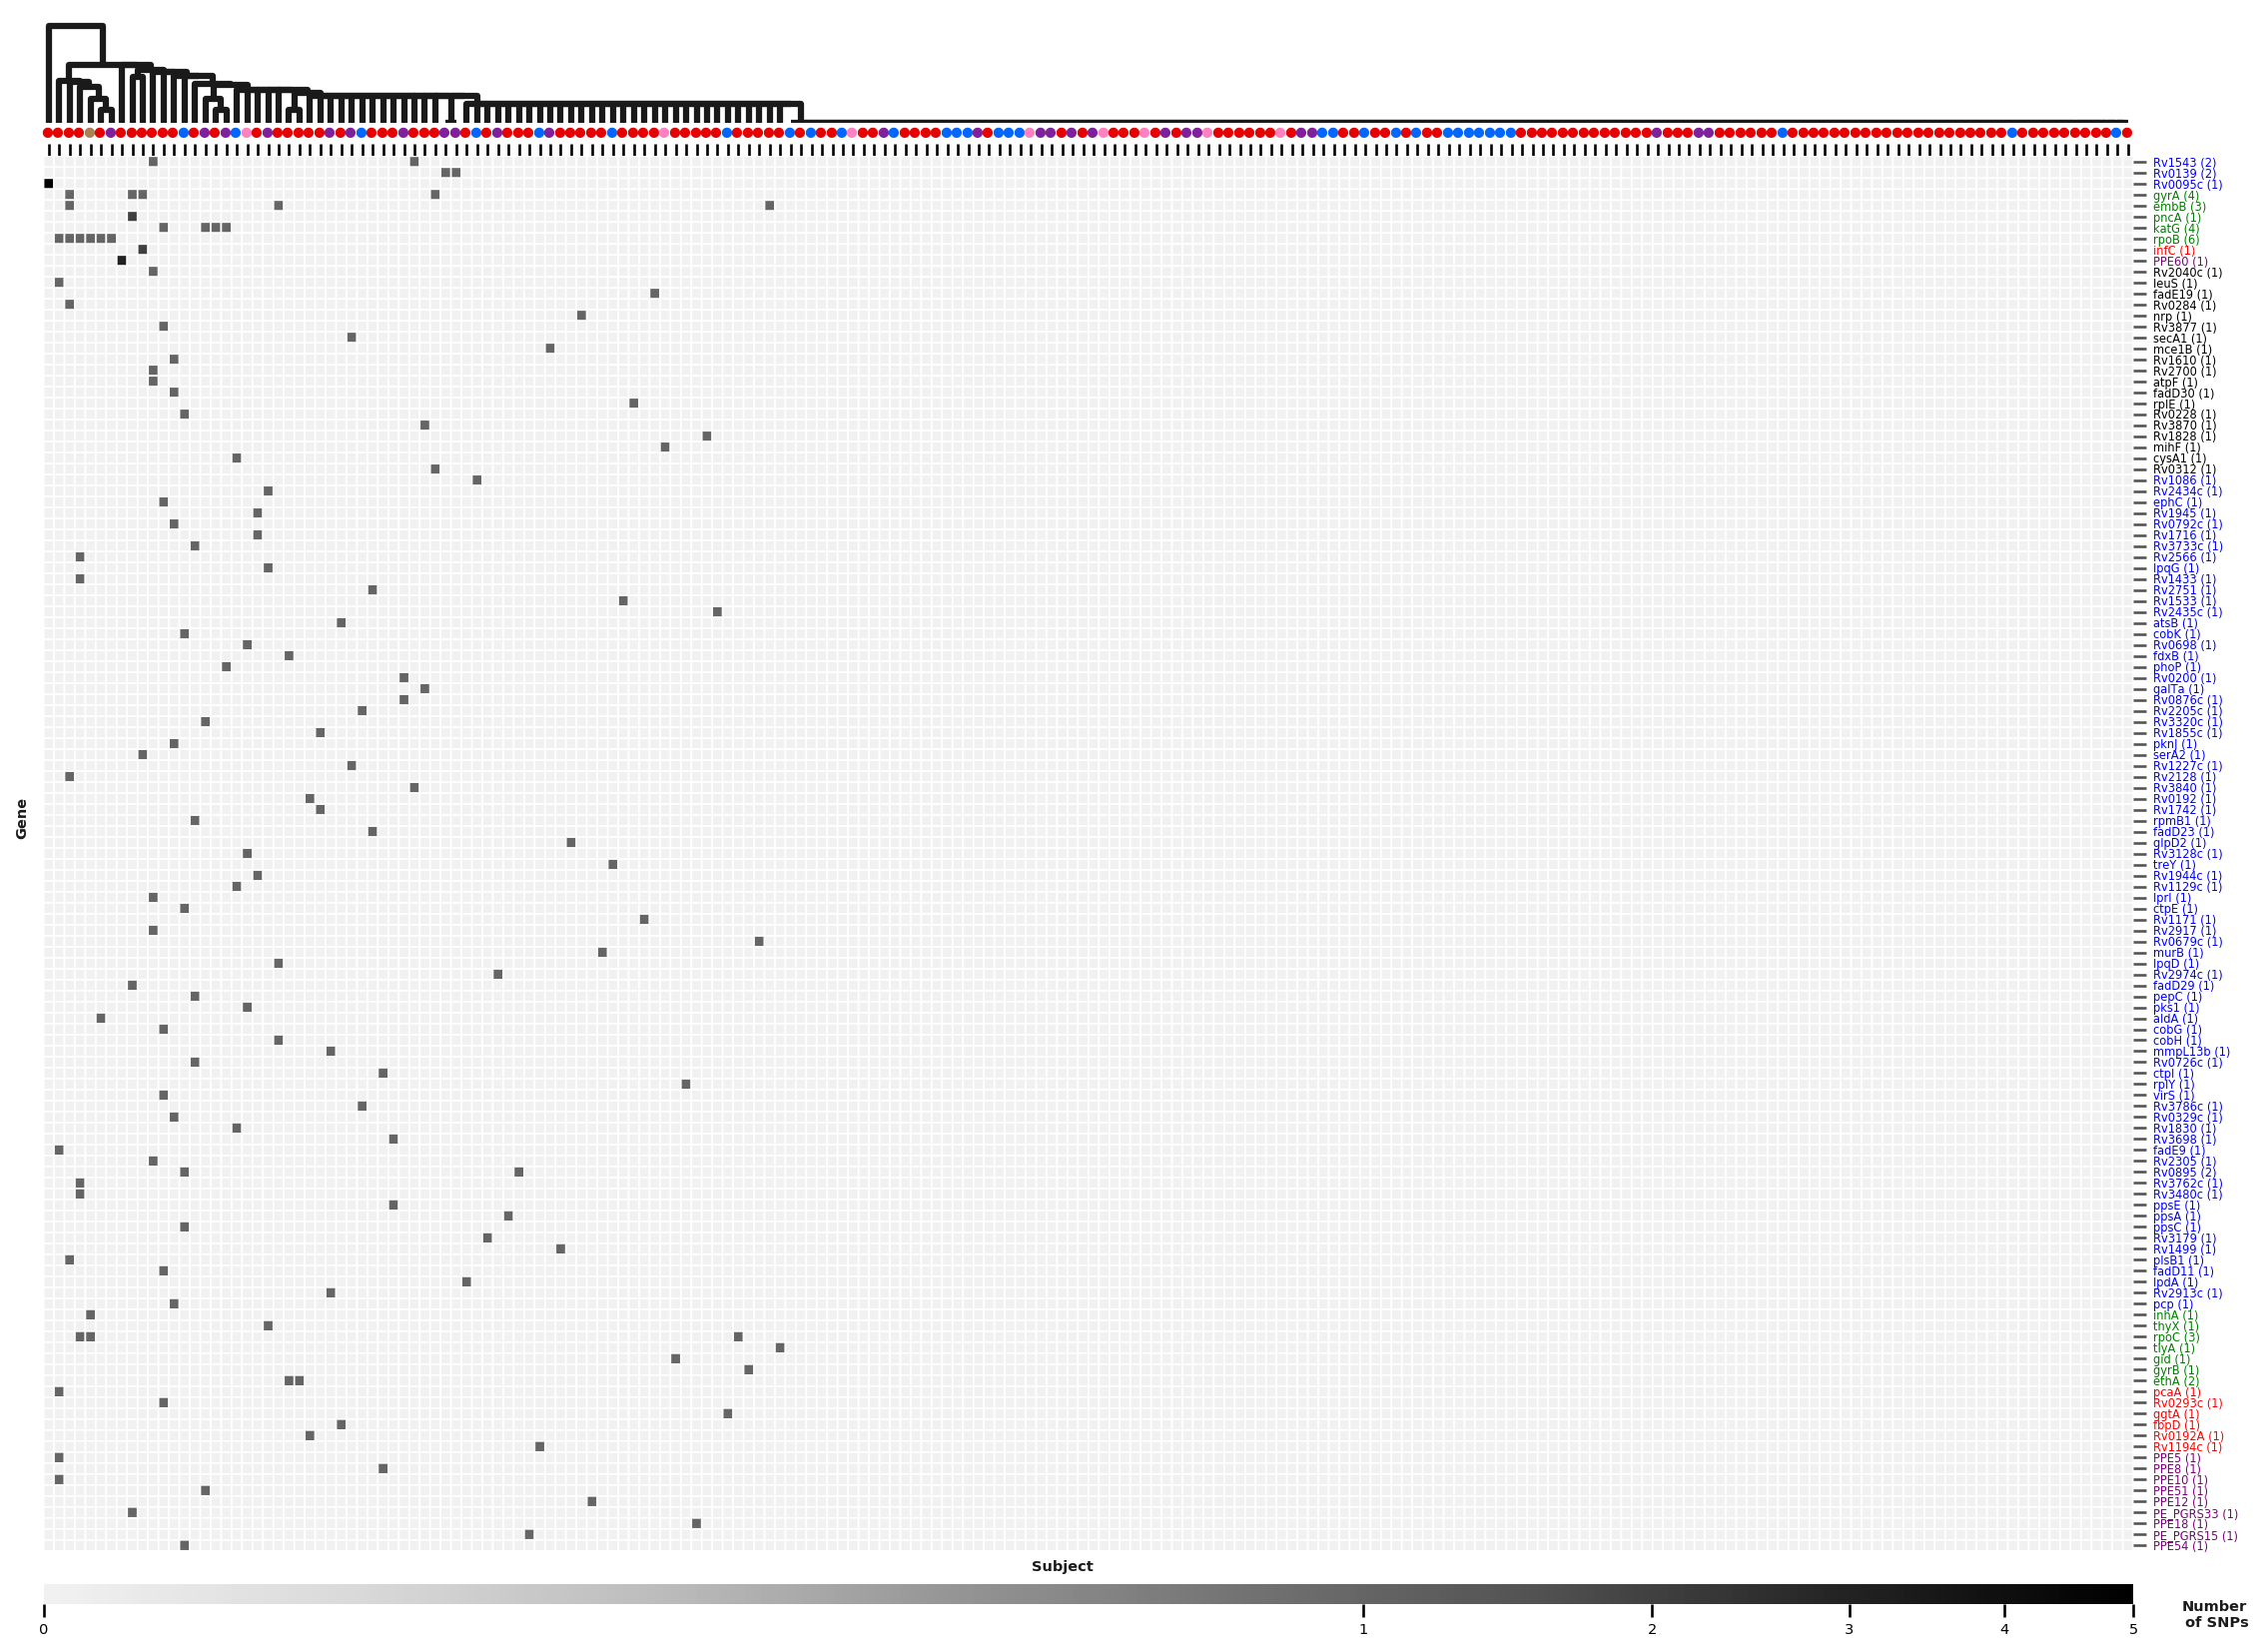

In [105]:
fig = plt.figure(figsize=(18.0, 14.0), dpi=150)
from matplotlib import gridspec
gs = gridspec.GridSpec(3, 1,
                       width_ratios = [1],
                       height_ratios = [5,68,1],
                       wspace=0.00,
                       hspace=0.065)

#define colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval), cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Greys')
trunc_cmap = truncate_colormap(cmap, 0.12, 1.0)

#cluster patients
patient_link = fastcluster.linkage(Gene_Patient_num_SNPs_DF.T , method = 'ward' , metric = 'euclidean')
patient_order = hier.leaves_list(patient_link)
reordered_data_subset = Gene_Patient_num_SNPs_DF.values[: , patient_order]

#HEATMAP
axmatrix = fig.add_subplot(gs[1])

# turn off the frame
axmatrix.set_frame_on(False)

#Y-TICKS (also append number of patients gene is mutated in)
#------------------------------------------------------------------------------------------------------------------------
gene_symbol_series = reference_genome_annotation.loc[Gene_Patient_num_SNPs_DF.index].symbol
for gene_id in gene_symbol_series.index:
    if isinstance(gene_symbol_series[gene_id] , str) == False:
        gene_symbol_series[gene_id] = gene_id + ' ' + '(' + str( num_patients_mutated_per_gene[gene_id] ) + ')'
        
    else:
        gene_symbol_series[gene_id] = gene_symbol_series[gene_id] + ' ' + '(' + str( num_patients_mutated_per_gene[gene_id] ) + ')'
        
axmatrix.set_yticks(np.arange(np.shape(Gene_Patient_num_SNPs_DF)[0]) + 0.5, minor=False)
axmatrix.yaxis.tick_right()
axmatrix.set_yticklabels(gene_symbol_series, rotation='horizontal', fontsize = 5)

#change color of xticks depending on gene category
colors_list_signif_genes = len(signif_genes_SNP_analysis_essential)*['black'] + len(signif_genes_SNP_analysis_non_essential)*['blue'] + len(signif_genes_SNP_analysis_antibiotic_resistance)*['green'] + len(signif_genes_SNP_analysis_antigen)*['red'] + len(signif_genes_SNP_analysis_family_protein)*['purple']
colors_list_non_signif_genes = len(non_signif_genes_SNP_analysis_essential)*['black'] + len(non_signif_genes_SNP_analysis_non_essential)*['blue'] + len(non_signif_genes_SNP_analysis_antibiotic_resistance)*['green'] + len(non_signif_genes_SNP_analysis_antigen)*['red'] + len(non_signif_genes_SNP_analysis_family_protein)*['purple']
colors_list = colors_list_signif_genes + colors_list_non_signif_genes 
[t.set_color(i) for (i,t) in zip(colors_list, axmatrix.yaxis.get_ticklabels())]

axmatrix.tick_params(labelsize=5.5 , pad = 3.5 , axis = 'y')
#------------------------------------------------------------------------------------------------------------------------

#X-TICKS
#------------------------------------------------------------------------------------------------------------------------
axmatrix.set_xticks(np.arange(np.shape(Gene_Patient_num_SNPs_DF)[1]) + 0.5, minor=False)
axmatrix.xaxis.tick_top()
#get a list of re-ordered patient IDs
re_ordered_patient_list = Gene_Patient_num_SNPs_DF.columns[patient_order]

#replace each patient id with an integer index & store corresponding color
patient_color_dict_re_ordered = []
integer_patient_id = 1
for patient_id in re_ordered_patient_list:
    
    patient_color_dict_re_ordered.append( [str(integer_patient_id) , patient_color_dict[patient_id] ] )
    integer_patient_id += 1
    
subject_labels = [r'$\bullet$'] * len(patient_color_dict_re_ordered)
axmatrix.set_xticklabels(subject_labels, rotation='vertical', fontsize = 17 , fontweight = 'bold')

colors_list = [patient_integer_id[1] for patient_integer_id in patient_color_dict_re_ordered]  #patient ID colors
[t.set_color(i) for (i,t) in zip(colors_list, axmatrix.xaxis.get_ticklabels())]

axmatrix.tick_params(labelsize=17 , pad = 0.1 , axis = 'x')
#------------------------------------------------------------------------------------------------------------------------

plt.gca().invert_yaxis()

norm = mpl.colors.PowerNorm(gamma=1./3.5)
heatmap = plt.pcolor(reordered_data_subset, cmap = trunc_cmap , norm = norm , edgecolors = '1.0', linewidth = 0.8)

#DENDROGRAM
#------------------------------------------------------------------------------------------------------------------------
patient_link_ax = fig.add_subplot(gs[0], frameon=False)
colors = ['k']*1000
Z1 = hier.dendrogram(patient_link, orientation='top', ax=patient_link_ax , link_color_func=lambda k: colors[k]) # adding/removing the axes
patient_link_ax.set_xticks([])
patient_link_ax.set_yticks([])
#------------------------------------------------------------------------------------------------------------------------

#COLORBAR
#------------------------------------------------------------------------------------------------------------------------
color_bar_ax = fig.add_subplot(gs[2])
cb = plt.colorbar(heatmap , cax = color_bar_ax , orientation = 'horizontal' , ticks = range(0, int(Gene_Patient_num_SNPs_DF.max().max())+1))
cb.outline.set_linewidth(0.0)
color_bar_ax.tick_params(labelsize=7 , pad = 3)
#------------------------------------------------------------------------------------------------------------------------

fig.text(0.503, 0.143, 'Subject' ,  ha='center', va='center', rotation=0, fontsize = 7 , color = 'k' , fontweight = 'bold')
fig.text(0.93, 0.12, 'Number\n of SNPs' ,  ha='center', va='center', rotation=0, fontsize = 7 , color = 'k', fontweight = 'bold')
fig.text(0.117, 0.50, 'Gene' ,  ha='center', va='center', rotation=90, fontsize = 7 , color = 'k', fontweight = 'bold')

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/longitudinal_SNP_analysis/SNPs_across_patients_and_genes.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)
    
plt.show()

#### Number of Subjects that had at least 1 SNP between serial isolates

In [106]:
np.shape(Gene_Patient_num_SNPs_DF)

(127, 200)

127 Genes (w/ at least 1 SNP) by 200 subjects (with paired serial isolates)

In [107]:
Gene_Patient_num_SNPs_DF.sum(axis = 0).sort_values(ascending = False).head()

KPS_10     7.0
P000226    7.0
2511       6.0
KPS_79     6.0
P000227    6.0
dtype: float64

In [108]:
Gene_Patient_num_SNPs_DF.sum(axis = 0).sort_values(ascending = False).tail()

1       0.0
34      0.0
28      0.0
32      0.0
2049    0.0
dtype: float64

In [109]:
print str( sum( Gene_Patient_num_SNPs_DF.sum(axis = 0) > 0.0 ) ) + ' subjects had at least 1 (coding) SNP between serial isolates'

71 subjects had at least 1 (coding) SNP between serial isolates


########################################################################################################################################################################################################################

## Output Genomic SNP coordinates (broken down by Gene & Subject) for further Nucleotide Diversity analysis

########################################################################################################################################################################################################################

In [110]:
SNP_variants_within_patients.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,alt_AF_diff,SNP_type,AA_change,symbol
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,1.00,N,H445D,rpoB
1,CASALI,P052,760314,G,T,Rv0667,508,Antibiotic Resistance,0.98,N,V170F,rpoB
2,WALKER,P000059,760314,G,T,Rv0667,508,Antibiotic Resistance,0.85,N,V170F,rpoB
3,WALKER,P000227,761277,A,T,Rv0667,1471,Antibiotic Resistance,0.99,N,I491F,rpoB
4,CETR,2511,761140,A,C,Rv0667,1334,Antibiotic Resistance,1.00,N,H445P,rpoB


In [111]:
Gene_Patient_num_SNPs_DF.sum().sum()

154.0

#### All SNPs (aggregated)

In [112]:
#subset to variants for all patients in a specific population
genetic_variants_across_all_patients = SNP_variants_within_patients.copy()

#set index to gene_id
genetic_variants_across_all_patients.set_index('gene_id' , drop = True , inplace = True)

#list of all patients
patient_list = list(set(sample_annotation.index))

#list of genes with at least 1 SNP
unique_genes = list(set(genetic_variants_across_all_patients.index))

#make empty dataframes
all_variants_genes_patients_SNP = pd.DataFrame(index = unique_genes, columns = patient_list)

for gene_id in unique_genes:

    #get the length of the gene for specifying x-axis of histogram and for checking for errors
    gene_length = reference_genome_annotation.loc[gene_id].length

    #yields all variants present in a given gene across all patients
    all_variants_for_gene = genetic_variants_across_all_patients.loc[gene_id]

    for patient_id in patient_list:

        #only 1 variant in gene across all patients
        if (len(np.shape(all_variants_for_gene)) == 1) and (all_variants_for_gene.patient_id == patient_id):
            all_variants_for_gene_patient = all_variants_for_gene

        #multiple variants in gene across all patients
        else:
            #variants on gene attributed to specific patient
            all_variants_for_gene_patient = all_variants_for_gene[all_variants_for_gene.patient_id == patient_id]

        #create lists that will contain positions of variants for this gene and this patient
        SNP_variant_positions = []

        #iterate through all variants for gene-patient and store in corresponding lists

        #if only 1 genetic variant across all patients for gene
        if len(np.shape(all_variants_for_gene_patient)) == 1:
            
            H37Rv_ref_position_i = all_variants_for_gene_patient.ref_position
            
            #find the genome relative start sites for H37Rv & Reference Genome for GeneID
            H37Rv_gene_start = reference_genome_annotation.loc[gene_id , 'chromStart']
            
            #find 5' - 3' gene-wise coordinate for SNP on H37Rv [location on H37Rv genome - start position of gene]
            ## ref_position (from Pilon) starts counting from 1 , H37Rv_start & H37Rv_end start counting from 0
            genomic_coord = (H37Rv_ref_position_i - 1) - (H37Rv_gene_start)
            
            SNP_variant_positions.append(genomic_coord)

        #if multiple genetic variants across all patients for gene
        if len(np.shape(all_variants_for_gene_patient)) == 2:
            num_rows = np.shape(all_variants_for_gene_patient)[0]

            for row_index in range(0, num_rows):
                
                H37Rv_ref_position_i = all_variants_for_gene_patient.ref_position[row_index]
                
                #find the genome relative start sites for H37Rv & Reference Genome for GeneID
                H37Rv_gene_start = reference_genome_annotation.loc[gene_id , 'chromStart']

                #find 5' - 3' gene-wise coordinate for SNP on H37Rv [location on H37Rv genome - start position of gene]
                ## ref_position (from Pilon) starts counting from 1 , H37Rv_start & H37Rv_end start counting from 0
                genomic_coord = (H37Rv_ref_position_i - 1) - (H37Rv_gene_start)

                SNP_variant_positions.append(genomic_coord)

        #make positions integers
        SNP_variant_positions = [int(x) for x in SNP_variant_positions]

        #store lists in appropriate dataframe for gene-row and patient-column
        all_variants_genes_patients_SNP.loc[gene_id, patient_id] = SNP_variant_positions

#save the resulting DataFrames as csv files
all_variants_genes_patients_SNP.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/variant_calling/filtered_longitudinal_SNP_positions_by_subject/all_SNPs_by_patient_and_gene.csv', ',')